In [183]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import tree, svm, naive_bayes,neighbors
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_recall_curve  ###计算roc和auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier


In [184]:
# read in data
STATISTICAL = '2016_se1_lib_lms.csv'
student_features = pd.read_csv(STATISTICAL)
df_se1_features = student_features[[i for i in student_features.columns if i != 'label_atRist' and i != 'MASKED_STUDENT_ID']]
df_se1_labels = student_features['label_atRist']
labels = df_se1_labels.apply(lambda x: str(x))

In [185]:
# only somte on train set
student_features.columns

Index(['MASKED_STUDENT_ID', 'workday', 'weekend', 'morning', 'afternoon',
       'evening', 'overnight', 'workday_ExamMonth', 'weekend_ExamMonth',
       'morning_ExamMonth', 'afternoon_ExamMonth', 'evening_ExamMonth',
       'overnight_ExamMonth', 'workday_notExamMonth', 'weekend_notExamMonth',
       'morning_notExamMonth', 'afternoon_notExamMonth',
       'evening_notExamMonth', 'overnight_notExamMonth', 'workday_firstMonth',
       'weekend_firstMonth', 'morning_firstMonth', 'afternoon_firstMonth',
       'evening_firstMonth', 'overnight_firstMonth', 'examMonth',
       'notExamMonth', 'firstMonth', 'total_checkin', 'label_atRist',
       '09LOGIN_ATTEMPT', '09SESSION_TIMEOUT', '09LOGOUT', '09group', '09db',
       '09myinfo', '09course', '09journal', '09email', '09staff',
       '09annoucements', '09content', '09grade', '10LOGIN_ATTEMPT',
       '10SESSION_TIMEOUT', '10LOGOUT', '10group', '10db', '10myinfo',
       '10course', '10journal', '10email', '10staff', '10annoucements',
 

In [63]:
ros = RandomOverSampler(random_state=0)
X_resampled_smote, y_resampled_smote = ros.fit_sample(df_se1_features, df_se1_labels)


# X_resampled_smote, y_resampled_smote = SVMSMOTE(random_state=1, sampling_strategy='auto',k_neighbors=10).fit_sample(df_se1_features, df_se1_labels)
print(y_resampled_smote.sum())
y_resampled_smote.shape

15122


(30244,)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(df_se1_features, df_se1_labels, test_size=0.2, stratify=df_se1_labels)

X_resampled_smote, y_resampled_smote = SMOTE(random_state=0, sampling_strategy='auto',k_neighbors=10).fit_sample(X_train, y_train)

# ros = RandomOverSampler(random_state=0)
# X_resampled_smote, y_resampled_smote = ros.fit_sample(X_train, y_train)

# X_resampled_smote, y_resampled_smote = ADASYN().fit_sample(X_train, y_train)

# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=0)
# X_resampled_smote, y_resampled_smote = smote_enn.fit_sample(X_train, y_train)

# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled_smote, y_resampled_smote = rus.fit_sample(X_train, y_train)

# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=0)
# X_resampled_smote, y_resampled_smote = smote_tomek.fit_sample(X_train, y_train)


# print(y_resampled_smote.sum())
# print(y_resampled_smote.shape)

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

clfs = {
        'svm': svm.SVC(class_weight='balanced'),\
        'decision_tree':tree.DecisionTreeClassifier(),\
        'naive_gaussian': naive_bayes.GaussianNB(), \
        'naive_mul':naive_bayes.MultinomialNB(),\
        'K_neighbor' : neighbors.KNeighborsClassifier(),\
        'bagging_knn' : BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5,max_features=0.5),\
        'bagging_tree': BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5,max_features=0.5),\
        'random_forest' : RandomForestClassifier(n_estimators=100),\
        'balanced_rf':BalancedRandomForestClassifier(n_estimators=200, criterion = 'gini', max_features = 1.0, random_state=0),
        'adaboost':AdaBoostClassifier(n_estimators=50),\
        'gradient_boost' : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=10, random_state=42, min_samples_leaf=1),
        'bbc' : BalancedBaggingClassifier(base_estimator=tree.DecisionTreeClassifier(),
                                ratio='auto',
                                replacement=False,
                                random_state=0)

}

def try_different_method(clf):
    # clf.fit(X_train, y_train.ravel())
    clf.fit(X_resampled_smote, y_resampled_smote.ravel())
    y_predprob = clf.predict_proba(X_test)[:,1]
    
    # features_imp = clf.feature_importances_
    # X_new = X_resampled_smote[:, clf.feature_importances_>0]
    # X_test_new = X_test[:, clf.feature_importances_>0]
    # clf.fit(X_new,y_resampled_smote.ravel())        
    return y_predprob

    
# y_predprob = np.array([0]*len(y_test))
clf_keys = ['decision_tree', 'bagging_tree', 'random_forest', 'balanced_rf', 'gradient_boost']
# clf_keys = ['balanced_rf']
best_auc = 0
predprob = []
for clf_key in clf_keys:
    print('the classifier is :',clf_key)
    clf = clfs[clf_key]
    y_predprob = try_different_method(clf)
    fpr,tpr,threshold = roc_curve(y_test, y_predprob)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    if best_auc < roc_auc:
        best_auc = roc_auc
        predprob = y_predprob

the classifier is : decision_tree
0.5184819486733363
the classifier is : bagging_tree
0.6261787733797304
the classifier is : random_forest
0.7421378860374077
the classifier is : balanced_rf
0.7249608525445845
the classifier is : gradient_boost
0.7720922140060896


In [180]:
j = 0
best_f1 = 0
while j < 1:
    predictions = np.array([1 if i > j else 0 for i in predprob])
    '''
    print('Sum of predictions:', predictions.sum())
    print('Sum of Y test:', y_test.sum())
    pos_recall = recall_score(y_test, predictions, pos_label=1)
    print('the at-risk recall is :', pos_recall)
    neg_recall = recall_score(y_test, predictions, pos_label=0)
    print('the normal recall is :', neg_recall)
    '''
    score = f1_score(y_test, predictions, average='macro')
    if best_f1 < score:
        print('the macro F-score is :', score)
        print('current j is:', j)
        best_f1 = score
    j += 0.001

/home/wenzhy/.conda/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


the macro F-score is : 0.02392193893610324
current j is: 0
the macro F-score is : 0.3373532222188186
current j is: 0.001
the macro F-score is : 0.4422451863984659
current j is: 0.002
the macro F-score is : 0.4885806072906412
current j is: 0.003
the macro F-score is : 0.5088513267902581
current j is: 0.004
the macro F-score is : 0.5114192203848661
current j is: 0.005
the macro F-score is : 0.5182690388115788
current j is: 0.006
the macro F-score is : 0.5241245666471886
current j is: 0.007
the macro F-score is : 0.5306975517061658
current j is: 0.008
the macro F-score is : 0.5395234296872844
current j is: 0.009000000000000001
the macro F-score is : 0.5430068957846735
current j is: 0.010000000000000002
the macro F-score is : 0.5476255342499633
current j is: 0.011000000000000003
the macro F-score is : 0.5515918384910244
current j is: 0.012000000000000004
the macro F-score is : 0.5555074208294768
current j is: 0.013000000000000005
the macro F-score is : 0.5597242535430511
current j is: 0.01

In [182]:
    j = 0.02100000000000001
    predictions = np.array([1 if i > j else 0 for i in predprob])
    print('Sum of predictions:', predictions.sum())
    print('Sum of Y test:', y_test.sum())
    pos_recall = recall_score(y_test, predictions, pos_label=1)
    print('the at-risk recall is :', pos_recall)
    neg_recall = recall_score(y_test, predictions, pos_label=0)
    print('the normal recall is :', neg_recall)
    score = f1_score(y_test, predictions, average='macro')
    print('the macro F-score is :', score)
    score = f1_score(y_test, predictions, average='micro')
    print('the micro F-score is :', score)

Sum of predictions: 145
Sum of Y test: 76
the at-risk recall is : 0.2631578947368421
the normal recall is : 0.9586776859504132
the macro F-score is : 0.5753664886015368
the micro F-score is : 0.9416317316994518


In [34]:
def get_pr(pos_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(pos_prob)[::-1]
    y = y_true[pos_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    auc = 0.0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]
        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
    return precision,recall,auc

<Figure size 432x288 with 0 Axes>

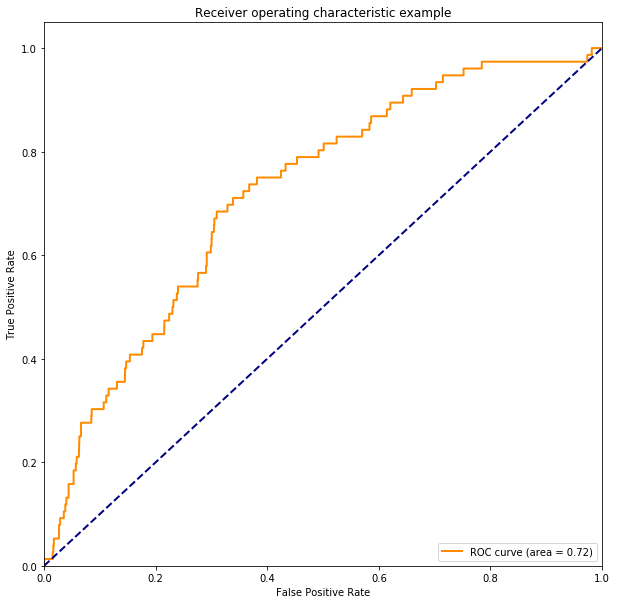

In [114]:
fpr,tpr,threshold = roc_curve(y_test, predprob)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/home/wenzhy/.conda/envs/py3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


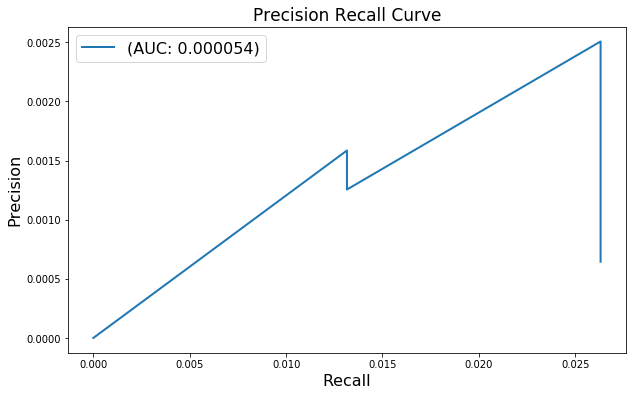

In [94]:
precision_lr,recall_lr,auc_lr = get_pr(predprob, y_test)

plt.figure(figsize=(10,6))
plt.plot(recall_lr,precision_lr,label="(AUC: {:.6f})".format(auc_lr),linewidth=2)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision Recall Curve",fontsize=17)
plt.legend(fontsize=16)

In [85]:
predprob

array([ -6.02980283, -11.41655766,  -8.28326678, ...,  -8.40883856,
        -8.2470736 ,  -6.11169668])

In [66]:
# without somte
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_se1_features, df_se1_labels, test_size = 0.2, stratify=df_se1_labels)
# from sklearn import tree, svm, naive_bayes,neighbors
# from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
clfs = {
#         'svm': svm.SVC(),\
#         'decision_tree':tree.DecisionTreeClassifier(),
#         'naive_gaussian': naive_bayes.GaussianNB(), \
#         'naive_mul':naive_bayes.MultinomialNB(),\
#         'K_neighbor' : neighbors.KNeighborsClassifier(),\
#         'bagging_knn' : BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5,max_features=0.5), \
#         'bagging_tree': BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5,max_features=0.5),
#         'random_forest' : RandomForestClassifier(n_estimators=50),\
#         'adaboost':AdaBoostClassifier(n_estimators=50),\
        'gradient_boost' : GradientBoostingClassifier(n_estimators=50, learning_rate=0.5,max_depth=10, random_state=0, min_samples_leaf=2)
        }

def try_different_method(clf):
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Sum of predictions:', predictions.sum())
    print('Sum of Y test:', y_test.sum())
    neg_recall = recall_score(y_test, predictions, pos_label=1)
    print('the neg recall is :', neg_recall)
    pos_recall = recall_score(y_test, predictions, pos_label=0)
    print('the pos recall is :', pos_recall)
    score = f1_score(y_test, predictions, average='micro')
    print('the micro F-score is :', score)

for clf_key in clfs.keys():
    print('the classifier is :',clf_key)
    clf = clfs[clf_key]
    try_different_method(clf)

the classifier is : gradient_boost
Sum of predictions: 86
Sum of Y test: 76
the neg recall is : 0.02631578947368421
the pos recall is : 0.9722314049586777
the micro F-score is : 0.9490486939696872
